In [1]:
from mtcnn import MTCNN
import os, sys, json
import cv2
sys.path.append('../')
from preprocess_dataset.TFRHelper import *
from utils.device_data import device_data2 as device_data
import concurrent.futures
import multiprocessing
import tensorflow as tf
import time
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [22]:
def parse_data_load(npz_data):
    landmarks = npz_data['landmark']
    face_roi = npz_data['face_roi']
    landmarks = np.array(landmarks) + [face_roi[0], face_roi[1]]
    xy_cam = np.divide(npz_data['gaze_mm'], 10) # in centimeter
    device_name = npz_data['device']
    orientation = npz_data['orientation']

    return landmarks, xy_cam, device_name, orientation

def parse_img_load(image_data):
    byte_img = image_data['bytes']
    nparr = np.frombuffer(byte_img, np.uint8)
    decoded_frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    return decoded_frame

def get_face(img_data, data):
    temp_lm, xycam, device_name, orientation = parse_data_load(data)
    decoded_frame = parse_img_load(img_data)
    decoded_frame = cv2.cvtColor(decoded_frame, cv2.COLOR_BGR2RGB)

    x, y = np.transpose(temp_lm)
    face_bbox = get_face_roi2(decoded_frame, temp_lm, 240, 240, padding=1)

    face = crop_image(decoded_frame, face_bbox)
    resized = cv2.resize(face, (240, 240))
    return decoded_frame, resized

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


In [54]:
data_path = '/media/gabe/bradisk_2/vc-one-preprocessed_new/'

In [56]:
mturks_folders = os.listdir(data_path + '/mturk')
mturks_folders.remove('.DS_Store')
# mturks_folders.remove('._.DS_Store')
mturk_paths = []
for mturk_folder in mturks_folders:
    uids = os.listdir(os.path.join(data_path, 'mturk', mturk_folder))
    uids = [os.path.join(data_path, 'mturk', mturk_folder, uid) for uid in uids]
    mturk_paths.append(uids)
mturk_paths = sum(mturk_paths, [])

Unsupported device: xt1706


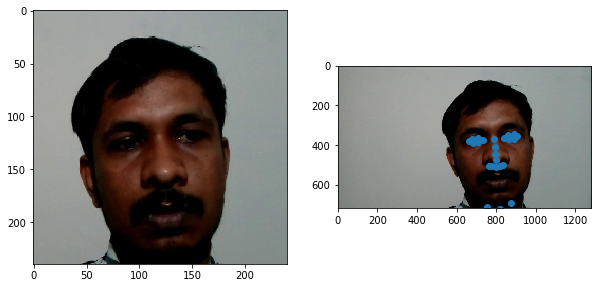

In [57]:
subject_path = np.random.choice(mturk_paths)

device_json = json.load(open(os.path.join(subject_path, 'device.json')))
# manufacturer = device_json['manufacturer'].lower()
device_model = device_json['model'].lower()

if (device_model not in list(device_data.keys())):
    print(f'Unsupported device: {device_model}')

subject = os.path.basename(subject_path)
sequences = os.listdir(subject_path)
sequences = [x for x in sequences if '.npz' in x]

sequence = np.random.choice(sequences)

npz_file = np.load(os.path.join(subject_path, sequence), allow_pickle=True)
img_load = npz_file['image'][()]
data_load = npz_file['data'][()]

frame_ids = list(img_load.keys())

frame_id = np.random.choice(frame_ids)

img_data = img_load[frame_id]
data = data_load[frame_id]

temp_lm, xycam, device_name, orientation = parse_data_load(data)
decoded_frame = parse_img_load(img_data)
decoded_frame = cv2.cvtColor(decoded_frame, cv2.COLOR_BGR2RGB)

x, y = np.transpose(temp_lm)
face_bbox = get_face_roi2(decoded_frame, temp_lm, 240, 240, padding=1.0)

face = crop_image(decoded_frame, face_bbox)
face = cv2.resize(face, (240, 240))

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(face)
axes[1].scatter(x, y)
axes[1].imshow(decoded_frame)

In [62]:
data

{'manufacturer': 'motorola',
 'gaze_pixel': [344, 624],
 'device': 'xt1706',
 'gaze_mm': [-62.116485839057695, -18.693464131498775],
 'landmark': [[229.66200971603394, 638.2500389417013],
  [292.85019969940186, 647.6298820177714],
  [349.94359588623047, 621.253148317337],
  [262.9666895866394, 297.37323947747547],
  [267.2734889984131, 335.20403059323627],
  [271.25487327575684, 371.4245090484619],
  [273.9226908683777, 402.5877290566762],
  [239.72997665405273, 431.885315656662],
  [255.20947313308716, 435.2171601454417],
  [275.32096910476685, 438.1325626373291],
  [294.78665924072266, 432.02656348546344],
  [309.719313621521, 427.06453291575116],
  [136.0608184337616, 308.16049607594806],
  [154.54102563858032, 294.9905372063319],
  [180.8611569404602, 292.0724095106125],
  [206.35900163650513, 303.5061050256093],
  [184.73077201843262, 313.2324860493342],
  [157.46693682670593, 316.68413666884106],
  [314.08149909973145, 293.1441601912181],
  [336.6822986602783, 276.68937945365906]

In [66]:
encoded_face = tf.io.encode_jpeg(face, quality=100).numpy() 
feature = {
    'image': _bytes_feature(encoded_face),
}

In [69]:
def convert_to_tfrecord(subject_path):
    device_json = json.load(open(os.path.join(subject_path, 'device.json')))
    # manufacturer = device_json['manufacturer'].lower()
    device_model = device_json['model'].lower()

    if (device_model not in list(device_data.keys())):
        print(f'Unsupported device: {device_model}')
        return None

    subject = os.path.basename(subject_path)
    sequences = os.listdir(subject_path)
    sequences = [x for x in sequences if '.npz' in x]
    tfrecord_path = os.path.join(write_path, f'{subject}.tfrecords')

    print(f"Converting {subject} to tfrecord - {len(sequences)}")

    with tf.io.TFRecordWriter(tfrecord_path) as writer:
        for sequence in sequences:
            npz_file = np.load(os.path.join(subject_path, sequence), allow_pickle=True)
            img_load = npz_file['image'][()]
            data_load = npz_file['data'][()]

            frame_ids = img_load.keys()

            for frame_id in frame_ids:
                img_data = img_load[frame_id]
                data = data_load[frame_id]
                face = get_face(img_data, data)

                encoded_face = tf.io.encode_jpeg(face, quality=100).numpy() 
                
                feature = {
                    'image': _bytes_feature(encoded_face),
                }                
                
                example = tf.train.Example(features=tf.train.Features(feature=feature))
                writer.write(example.SerializeToString())